# Udacity Self-Driving Car Engineer Nanodegree

## Project: **Finding Lane Lines** 
***
The goal of this project is to highligh lane lines in a number of still images and short videos. This is achived with an image processing pipline. This pipline used here closesly follows the predvious lessons in the SDCEN program and includes the following processing steps:

    * Grayscale
    * guassian blur
    * Canny Edge Detection
    * Regoin of Intrest Masking
    * Huge line transform line detection
    * Line slope categorization, x-y location averaging, and extrapolation 

***
The finished pipline identifies lane lines in the still pictures and videos similar to the included examples.


## Import Packages
** Step one is importing some packages. Here are the ones from the lessons, plus a few extras.**

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os, glob
import math
%matplotlib inline

# for the movies
from moviepy.editor import VideoFileClip
from IPython.display import HTML


## Reading in Images
***
To get started, I read in the test images and plotted them as is with code from the lesson. There are a few things that may cause difficulties such as some some small horizontal lines that might make it through the processing steps, though the images are mostly open, straight road under reasonable light. 
***

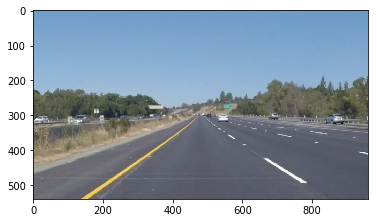

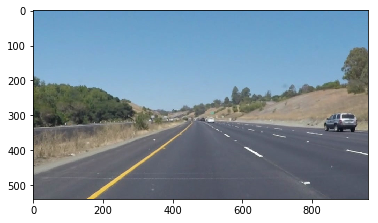

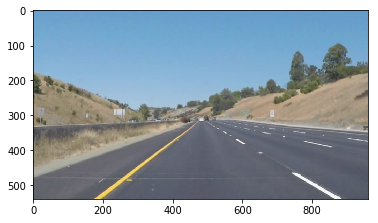

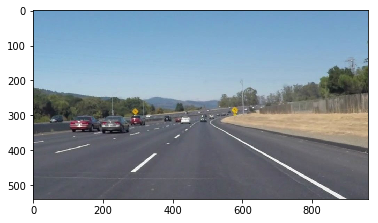

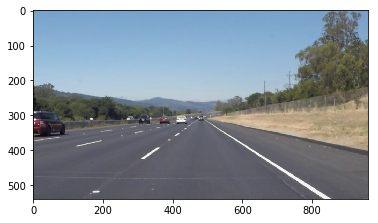

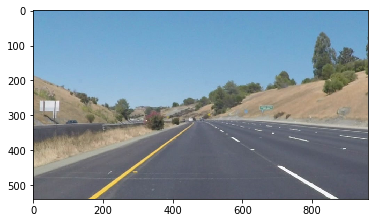

In [305]:
#reading in and plotting raw images
images = os.listdir("test_images/")

test_images = []
for img in images:
    test_images.append(mpimg.imread("test_images/" + img))
    plt.figure()
    plt.imshow(mpimg.imread("test_images/" + img))


## Processing functions

***
Here are the processing functions used to build the pipline to identify the lanes. These are mainly from the helper functions and have some tuned paramters, defaults added. 
***

In [347]:
#=============================================================
# functions required for pipline

# convert to grayscale, call plt.imshow(gray, cmap='gray') to plot.
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# canny edge detection low high thresholds likely between 0 and 200, roughly 100 or so apart
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

# blur to highlight straight lines, kernel size is positie and odd number. try 5 - 25
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# ROI mask veritices is a np.array, using dimentions from lesson  
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# added defaults 
def weighted_img(img, initial_img, α=0.7, β=0.3, λ=0):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


# I dont need this function for my pipeline, but using for comparison
#  hough lines function from starter functions 
def hough_lines(img, rho = 1, theta = 0.0017, threshold = 20, min_line_len = 20, max_line_gap = 280):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # from draw lines function
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), [255, 0, 0], 15)
    return line_img

## Pre-line extrapolation check
***
Before diving into the final stage, the line classifier is outputting the below figures.
The classifier is currently working ok, although the lines are not extended across the
whole visible lane and there are some extraneous lines (image 6 on the left side).
***

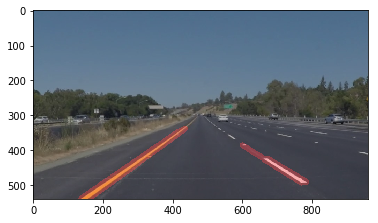

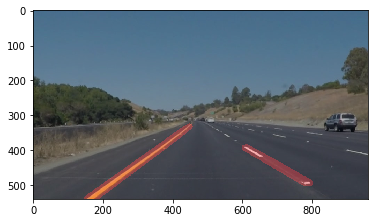

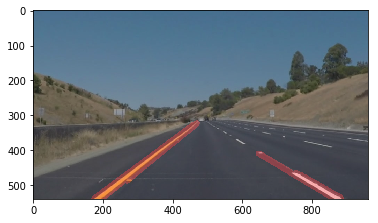

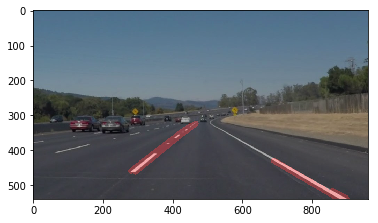

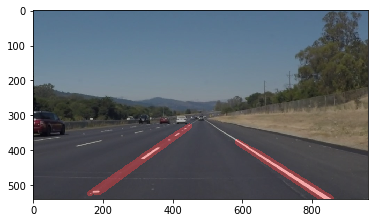

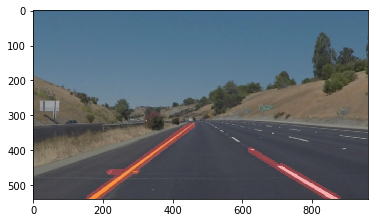

In [348]:
# test pipline 
def test_lines(img):
    #img1 = select_rgb_white_yellow(img) # source [1]
    img2 = grayscale(img)
    img3 = gaussian_blur(img2, kernel_size = 5)
    img4 = canny(img3, 50, 150)
    
    # define the roi extents
    left_bottom = [0, 539]
    right_bottom = [900, 539]
    apex = [475, 320]
    vertices = np.array([[left_bottom, right_bottom, apex]], dtype=np.int32)
    
    # cut image to roi
    img_roi = region_of_interest(img4, vertices)
    
    # hough transform from helper functions
    img6 = hough_lines(img_roi)
    img7 = weighted_img(img6, img)
    return img7

# loop through the test images and plot result
for img in test_images:
    plt.figure()
    plt.imshow(test_lines(img))

## Finishing the lines
***
To finish the lines, I used the output of houghlinesp to calculate the mean points 
for one left and one right line. Then, using one point each, I calculated the intercept
of each line. From there, I assumed the y1 and y2 values of both lines to solve for 
x2 and x1 for both lines. Output is saved as a list of tuples. My answer was inspired by 
Naoki Shibuya (https://github.com/naokishibuya/car-finding-lane-lines), though his answer averages the slopes 
rather than the point locations, and employs weighted averaging by giving the longest 
lines more influence over the final slope. My answer is more simplistic, but could be
improved along the same thought process by using a weighted spatial average of point locations.
However, implemented here is just a simple average for each point component.

The second function plots the lines on an imput image, or, if the line is equal to 
the number 9999, the result I have if there are NaN objects in the first function, 
it just returns the original. This is not ideal, but was nessesary to get through
processing the whole second video.
***

In [362]:
# makes 1 average-ish line for each side by averaging the points and 
def average_lines(line_img):
    # hough lines function from lesson 
    lines = cv2.HoughLinesP(line_img, rho = 1, theta = 0.0017, threshold = 20, minLineLength = 20, maxLineGap=280)
    # initilize emtpy objects

    # initilize all objects for two lines defined by two points each
    # consant values though, for y1 and y2 as they will be middle and 
    #  bottom of image 
    r_x1_points = []
    r_x2_points = []
    r_y1_points = []
    r_y2_points = []
    l_x1_points = []
    l_x2_points = []
    l_y1_points = []
    l_y2_points = []

    for line in lines:
        # calculate individual line slope
        slope = ((line[0, 3] - line[0, 1]) / ( line[0, 2] - line[0, 0]))
        if slope > 0:
            r_x1_points.append(line[0, 0])
            r_x2_points.append(line[0, 2])
            r_y2_points.append(line[0, 3])
            r_y1_points.append(line[0, 1])
        if slope < 0: 
            l_x1_points.append(line[0, 0])
            l_x2_points.append(line[0, 2])
            l_y2_points.append(line[0, 3])
            l_y1_points.append(line[0, 1])
        
    # average the points before re-calculating one slope for R and L line
    r_x1_ave = np.mean(r_x1_points)
    r_x2_ave = np.mean(r_x2_points)
    r_y1_ave = np.mean(r_y1_points)
    r_y2_ave = np.mean(r_y2_points)
    l_x1_ave = np.mean(l_x1_points)
    l_x2_ave = np.mean(l_x2_points)
    l_y1_ave = np.mean(l_y1_points)
    l_y2_ave = np.mean(l_y2_points)
    
    ave_r_slope = (r_y2_ave - r_y1_ave) / (r_x2_ave - r_x1_ave)
    ave_l_slope = (l_y2_ave - l_y1_ave) / (l_x2_ave - l_x1_ave)
    
    l_yint = l_y2_ave - ave_l_slope * l_x2_ave
    r_yint = r_y2_ave - ave_r_slope * r_x2_ave
    
    # geometry 
    # y values for both are assumed to be 320 and 539
    #  this will extend the lines 
    l_y1_final = 320
    r_y1_final = 320
    l_y2_final = 539
    r_y2_final = 539
    
    # left side!!!
    l_x1_final = (l_y1_final - l_yint) / ave_l_slope
    l_x2_final = (l_y2_final - l_yint) / ave_l_slope
    
    # strong side!!!
    r_x1_final = (r_y1_final - r_yint) / ave_r_slope
    r_x2_final = (r_y2_final - r_yint) / ave_r_slope
    
    if math.isnan(r_x1_ave) or math.isnan(r_x2_ave) or math.isnan(r_y1_ave) or math.isnan(r_y2_ave) or math.isnan(l_x1_ave) or math.isnan(l_x2_ave) or math.isnan(l_y1_ave) or math.isnan(l_y2_ave):
        return [9999]
    else:
        #organize into line object for input_lines to draw lines
        r_p1 = (int(r_x1_final), int(r_y1_final))
        r_p2 =  (int(r_x2_final), int(r_y2_final))
        l_p1 = (int(l_x1_final), int(l_y1_final))
        l_p2 = (int(l_x2_final), int(l_y2_final))
        
        input_lines = [r_p1, r_p2, l_p1, l_p2]

        return input_lines

# Python 3 has support for cool math symbols. cool. 
def final_lane_lines(img, lines):
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if lines != [9999]:
        # write first line
        cv2.line(line_img, lines[0], lines[1], [255, 0, 0], 15)
        cv2.line(line_img, lines[2], lines[3], [255, 0, 0], 15)   
        
        return line_img
    # or blank image 
    else:
        return img

## Testing the pipeline on the provided images
***
Here, the pipeline was tested and iterated until a reasonalbe group of parameters
and function structures was achieved. Parameters included 
gussian kernel size (15), Canny edge detection low (50) and high (150) thresholds, ROI verticies, 
(I used a triangle as in the lesson), hough transform parameters
and image composite mixing parameters for final output
***

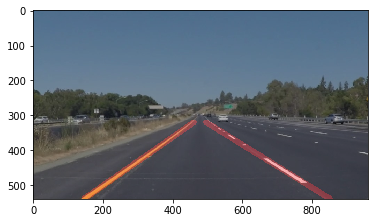

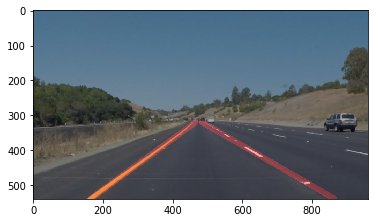

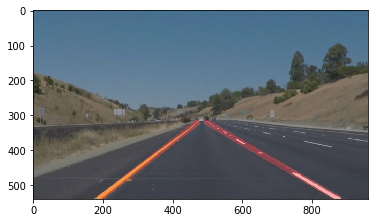

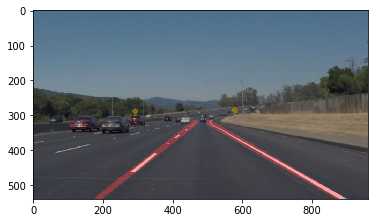

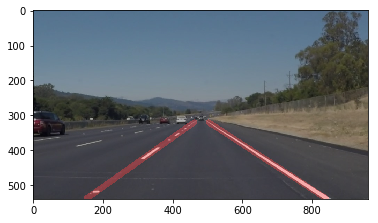

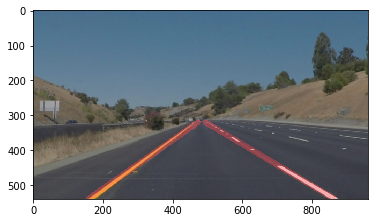

In [353]:
# put all together for the pipeline
def detect_lines(img):
    #img1 = select_rgb_white_yellow(img) # source [1]
    img2 = grayscale(img)
    img3 = gaussian_blur(img2, kernel_size = 5)
    img4 = canny(img3, 50, 150)
    
    # define the roi extents
    left_bottom = [0, 539]
    right_bottom = [900, 539]
    apex = [475, 320]
    vertices = np.array([[left_bottom, right_bottom, apex]], dtype=np.int32)
    
    # cut image to roi
    img_roi = region_of_interest(img4, vertices)
    
    # hough line transform, and location averaging and extrapolaiton through y-value assumptions
    input_lines = average_lines(img_roi)
    
    # draw the new lines over the original image
    img6 = final_lane_lines(img, input_lines)
    
    # mix the original and final images
    img7 = weighted_img(img6, img)
    return img7

# loop through the test images and plot result
for img in test_images:
    plt.figure()
    plt.imshow(detect_lines(img))

## Testing on Movie files

***
The pipeline was tested on the movie files. Below is the white lines movie.
The pipeline works, though is a bit shaky. 
Some other solutions to this problem employed more smoothing techniques, The simple
x or y direction point averaging I used is likely the cause of the inconsistancies 
between frames.
***

**Code for movie loading, calling the processing function, 
and dispay were included in the lesson**

In [363]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(detect_lines) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:06<00:00, 38.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.86 s, sys: 204 ms, total: 5.06 s
Wall time: 6.69 s


In [357]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Testing on the white and yellow lines moive 

***
The pipeline performs worse on the yellow and white lines movie, with a few visible 
missclassifications of roadside pixles as components of lane lines. Overall it still
identifies lanes well, however, near perfect accuracy is needed for an application 
like this. Further parameter tuning would improve performance, however, it is unlikey 
that this particular logic pipeline will generalize well to other road conditions, 
even if was tuned well to the movie examples given in this project.
***


In [364]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(2,3)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(detect_lines)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 95%|█████████▌| 648/682 [00:18<00:01, 33.88it/s]


100%|█████████▉| 681/682 [00:19<00:00, 34.36it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 15.9 s, sys: 664 ms, total: 16.5 s
Wall time: 20.3 s


In [365]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Conclusion

***
The pipeline is able to identify the lane lines in both the still images and the 
movie clips. The essential problem of classifying lane lines in images or a series of 
images is achived with a reasonably high accuracy. However, self driving cars require
very accurate technology, and this pipline is unlikely to perform well enough for any SDC
application. The pipeline of manually selected features which are used to identify lane
lines has major pitfalls. During the tuning process, it became clear that the classification
could fail on reletively simple cases, such as a car at the edge of the area of 
interest, or a edge line structure on the side of the road that survided the gaussian blur. These problems could be solved with 
further tuning and creating a complex manually defined logic pipeline to improve performance
and reliablility, however, adding logic will slow down the classifier and create oopportunities 
for bugs and faillures. For example, if it is raining, there may be line-like water streaks in the images, 
causing a number of unwanted lines which may have a lot of influence over the final averaged line. A more robust solution with fast process
time, such as a neural net, which replaced the need for manual feature selection, would be preferable to the pipline designed here, but would
require a large amount of labeled data (i.e., which pixesl are or arent lane lines, in many different stills) where as this pipeline does not.
***